In [104]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '.')))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.signal
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pipeline

0. Parse the manual behaviors labeling data
1. Extract the fluorescence traces from each video; count the number of spikes in each CB
2. Extract each elongation piece
3. Align all pieces by setting the length of the starting point (contracted) as 1
4. Plot the relationship between elongated length and the number of prior CB spikes 

In [380]:
results = defaultdict(lambda:[])

In [401]:
VIDEONAME = "Control-EGCaMP_exp1_a1_30x10fps"
VIDEOFPS = 5
ORIGFPS = 10

### Parse manual labels

In [402]:
# Load manual labels
df = pd.read_csv('./data/manual_labels/EGCaMP6_Manual_Imaging_Analysis - ' + VIDEONAME + '.csv', header=1)

In [403]:
# Reformat periods
def reformat_periods(periods, unit='sec'):
    
    for j in range(len(periods)):
        
        time_str_pair = periods[j].split('-')
        
        if len(time_str_pair) < 2:
            continue
        
        periods[j] = (reformat_time(time_str_pair[0], unit), reformat_time(time_str_pair[1], unit))
    
    if type(periods[-1]) == str:
        
        periods[-1] = (reformat_time(time_str_pair[0], unit), -1)
        
    return periods

def reformat_time(time_string, unit='sec'):
    
    time_pair = [int(x) for x in time_string.split(':')]
    
    if unit == 'sec':
        time_num = time_pair[-2]*60 + time_pair[-1]
        if len(time_pair) == 3:
            time_num += time_pair[-3]*3600
        
    elif unit == 'min':
        time_num = time_pair[-2] + time_pair[-1]/60
        if len(time_pair) == 3:
            time_num += time_pair[-3]*60
        
    elif unit == 'frame':
        time_num = (time_pair[-2]*60 + time_pair[-1]) * VIDEOFPS
        if len(time_pair) == 3:
            time_num += time_pair[-3]*3600 * VIDEOFPS
        
    return time_num

In [404]:
cb_periods = df[df.Behavior.str.contains('CB')]['Time of Event'].values
cb_periods = reformat_periods(cb_periods, unit='frame')
# cb_periods.sort()

In [405]:
elong_periods = []
for j in range(len(cb_periods)-1):
    elong_periods.append((cb_periods[j][1], cb_periods[j+1][0]))
elong_periods = np.array(elong_periods)

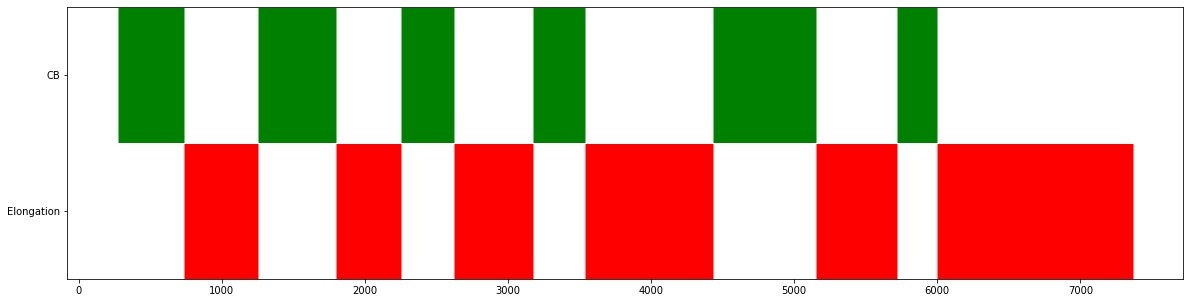

In [406]:
plt.figure(figsize=(20, 5))
for period in elong_periods:
    plt.hlines(1, period[0], period[1], colors='r', linewidth=135)
for period in cb_periods[:-1]:
    plt.hlines(2, period[0], period[1], colors='g', linewidth=135)
plt.yticks([1,2], ['Elongation', 'CB'])
plt.ylim(0.5, 2.5)
plt.show()

### Count CB spikes

In [407]:
FLUODIR = "./data/fluorescence/"
FLUONAME = "total_fluo_" + VIDEONAME + ".csv"

In [408]:
# Load fluorescence data
fluo = pd.read_csv(FLUODIR + FLUONAME).values.reshape(-1)
minfluo = min(fluo)
maxfluo = max(fluo)
fluo = [(x -minfluo) / (maxfluo - minfluo) for x in fluo]

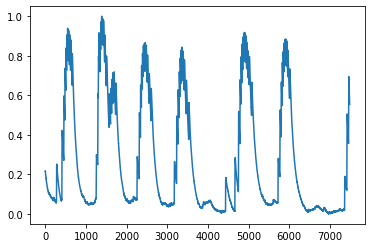

In [409]:
plt.plot(fluo)

In [410]:
spike_counts = []

for period in cb_periods[:-1]:
    
    fluo_piece = fluo[period[0]:period[1]]
    
    # Count the number of spikes
    peaks, _ = scipy.signal.find_peaks(fluo_piece, height=0.1, wlen=100, prominence=0.025)
    spike_counts.append(len(peaks))

In [411]:
spike_counts

[11, 16, 12, 10, 14, 10]

### Extract elongation pieces

In [412]:
LENDIR = "./data/midline/"
LENNAME = "lengths_" + VIDEONAME + ".csv"

In [413]:
# Load midline length
length = pd.read_csv(LENDIR + LENNAME).values.reshape(-1)

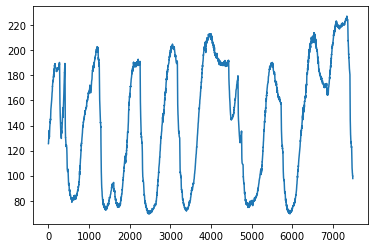

In [414]:
plt.plot(length)

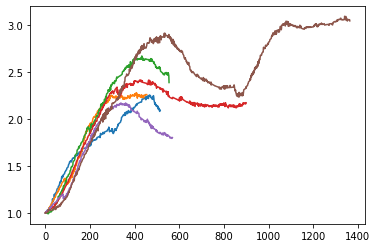

In [415]:
length_pieces = []
length_ratios = []

for period in elong_periods:
    
    len_piece = length[period[0]:period[1]]
    
    # Normalize the piece as ratio
    base = len_piece[0]
    len_piece = [x/base for x in len_piece]
    length_pieces.append(len_piece)
    length_ratios.append(max(len_piece))
    plt.plot(len_piece)

In [416]:
length_ratios

[2.253007344623481,
 2.278163715830072,
 2.6680494205539516,
 2.4121392226870833,
 2.1679543614985968,
 3.08994824325243]

### Save results

In [417]:
results['spikecounts_ratio'].extend([(spike_counts[j], length_ratios[j]) for j in range(len(spike_counts))])
results['length_pieces'].extend(length_pieces)

In [418]:
results['spikecounts_ratio']

[(6, 1.990149636531552),
 (9, 2.0929900555858696),
 (10, 2.230414727494814),
 (6, 2.3259366432221693),
 (9, 2.3333623748593437),
 (9, 2.351785428059457),
 (10, 2.940681729739436),
 (18, 2.3259380166861514),
 (14, 2.7374443829949544),
 (11, 2.742617361072939),
 (10, 2.551080065888702),
 (11, 2.573163029435172),
 (11, 2.253007344623481),
 (16, 2.278163715830072),
 (12, 2.6680494205539516),
 (10, 2.4121392226870833),
 (14, 2.1679543614985968),
 (10, 3.08994824325243)]

### Plot results

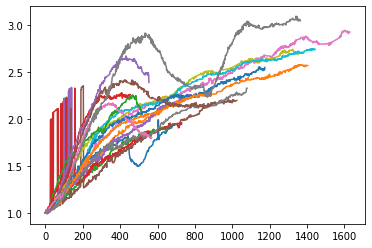

In [419]:
plt.figure()
for piece in results['length_pieces']:
    plt.plot(piece)
plt.show()

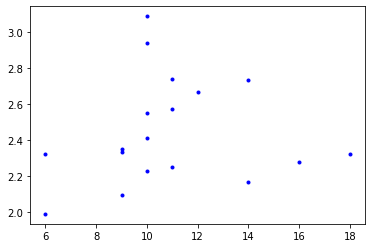

In [420]:
plt.figure()
for pair in results['spikecounts_ratio']:
    plt.plot(pair[0], pair[1], 'b.')
plt.show()